In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn import metrics


import copy
import warnings

warnings.filterwarnings("ignore")

np.random.seed(0)

pd.set_option("mode.copy_on_write", True)

In [2]:
# Reading the data (real world data)
real_training_data = pd.read_csv("../../01_Data/02_Processed/train.csv")
real_test_data = pd.read_csv("../../01_Data/02_Processed/test.csv")

In [3]:
# Extracting just the features (clean_tweet) and the labels (offensive yes/no)
real_x_train, real_y_train = (
    real_training_data.iloc[:, -1],
    real_training_data.iloc[:, 0],
)
real_x_test, real_y_test = real_test_data.iloc[:, -1], real_test_data.iloc[:, 0]
real_y_train = real_y_train.map({"Yes": 1, "No": 0})
real_y_test = real_y_test.map({"Yes": 1, "No": 0})

## Encoding text using the most frequent terms in the corpus

In [4]:
# padding with zeros - adding zeroes to the left of the sequence to make it of a fixed length for future analyses
def add_padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, tweet_numeric in enumerate(sentences):
        # print(i, tweet_numeric)
        if len(tweet_numeric) != 0:
            features[i, -len(tweet_numeric) :] = np.array(tweet_numeric)[:seq_len]
    return features


# Vectorize dataset - convert text to numbers
def tokenize_text(x_train, y_train, x_val, y_val):
    word_list = []

    for sentence in x_train:
        for word in sentence.split():
            if word != "":
                word_list.append(word)

    # make vocab dictionary
    corpus = Counter(word_list)  # count the number of each word occurs in the word list
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:5000]
    onehot_dictionary = {w: i + 1 for i, w in enumerate(corpus_)}
    # print("Corpus:", corpus)
    # print("Corpus_:", len(corpus_), corpus_)
    # print("onehot_dictionary:", len(onehot_dictionary), onehot_dictionary)
    # tokenize
    train_sent, test_sent = [], []
    for sent in x_train:
        train_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )
    for sent in x_val:
        test_sent.append(
            [
                onehot_dictionary[word]
                for word in sent.split()
                if word in onehot_dictionary.keys()
            ]
        )

    # Pad sequences - keeping the length as 30 because most tweets are 25 or less in length
    train_sent = add_padding(train_sent, 30)
    test_sent = add_padding(test_sent, 30)
    # print("train_sent: ", train_sent)
    # print("test_sent: ", test_sent)
    return (
        np.array(train_sent),
        np.array(y_train),
        np.array(test_sent),
        np.array(y_val),
        onehot_dictionary,
    )


print("x_train before Encoding: ", real_x_train.shape)
print("Encoding text as Numbers...")
r_x_train, r_y_train, r_x_test, r_y_test, vocab = tokenize_text(
    real_x_train, real_y_train, real_x_test, real_y_test
)
print("x_train after Encoding: ", r_x_train.shape)

x_train before Encoding:  (6400,)
Encoding text as Numbers...
x_train after Encoding:  (6400, 30)


In [5]:
print(f"Length of vocabulary is {len(vocab)}")

Length of vocabulary is 5000


## Discriminative process for classification - LSTM

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(r_x_train), torch.from_numpy(r_y_train.astype("int"))
)
valid_data = TensorDataset(
    torch.from_numpy(r_x_test), torch.from_numpy(r_y_test.astype("int"))
)

# dataloaders
batch_size = 50

# Shuffling the data and creating batches of data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [8]:
# obtain one batch of training data - this is just a check
iterated_data = iter(train_loader)
sample_x, sample_y = next(iterated_data)

print("Sample input size:", sample_x.size())  # batch_size, seq_length
print("Sample input features:", sample_x)
print("Sample input labels:", sample_y)

Sample input size: torch.Size([50, 30])
Sample input features: tensor([[   0,    0,    0,  ..., 1853,  724,  649],
        [   0,    0,    0,  ...,    4,   15,   75],
        [   0,    0,    0,  ...,  289,    9,  119],
        ...,
        [   0,    0,    0,  ...,   59,  931,  215],
        [   0,    0,    0,  ...,  991,   58,  166],
        [   0,    0,    0,  ...,  291,  100,  393]])
Sample input labels: tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0])


# LSTM Classifier Architecture

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dim, embedding_dim):
        super(LSTMClassifier, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.n_layers = n_layers
        self.vocab_size = vocab_size

        # embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.n_layers,
            batch_first=True,
            dropout=0.2,
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        # linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """Initializes hidden state"""
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [10]:
# For GPU usage, if available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Model 3A - Discriminative Model trained on Real Data

In [11]:
# Model Hyperparameters
n_layers = 2
vocab_size = len(vocab) + 1  # extra 1 for padding
embedding_dim = 30
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers, vocab_size, hidden_dim, embedding_dim)

# moving to GPU (if available)
model.to(device)

print(model)

LSTMClassifier(
  (embedding): Embedding(5001, 30)
  (lstm): LSTM(30, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### LSTM Training on Real Data

In [12]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [13]:
clip = 5
epochs = 5
best_loss = float("inf")
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(
        epoch + 1,
        epochs,
        epoch_train_loss,
        epoch_val_loss,
        epoch_train_acc * 100,
        epoch_val_acc * 100,
    )
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), "state_dict.pt")
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                best_loss, epoch_val_loss
            )
        )
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70 * "==")

Epoch[1/5], Train Loss: 0.4650 | Valid Loss: 0.3252 | Train Acc: 77.56 | Valid Acc: 87.44
Validation loss decreased (inf --> 0.325242).  Saving model ...
Epoch[2/5], Train Loss: 0.2691 | Valid Loss: 0.2653 | Train Acc: 90.22 | Valid Acc: 90.62
Validation loss decreased (0.325242 --> 0.265321).  Saving model ...
Epoch[3/5], Train Loss: 0.2203 | Valid Loss: 0.2358 | Train Acc: 92.36 | Valid Acc: 91.69
Validation loss decreased (0.265321 --> 0.235812).  Saving model ...
Epoch[4/5], Train Loss: 0.1821 | Valid Loss: 0.2234 | Train Acc: 93.86 | Valid Acc: 93.06
Validation loss decreased (0.235812 --> 0.223422).  Saving model ...
Epoch[5/5], Train Loss: 0.1465 | Valid Loss: 0.1980 | Train Acc: 95.03 | Valid Acc: 93.75
Validation loss decreased (0.223422 --> 0.198024).  Saving model ...


### Model Evaluation against Real Data

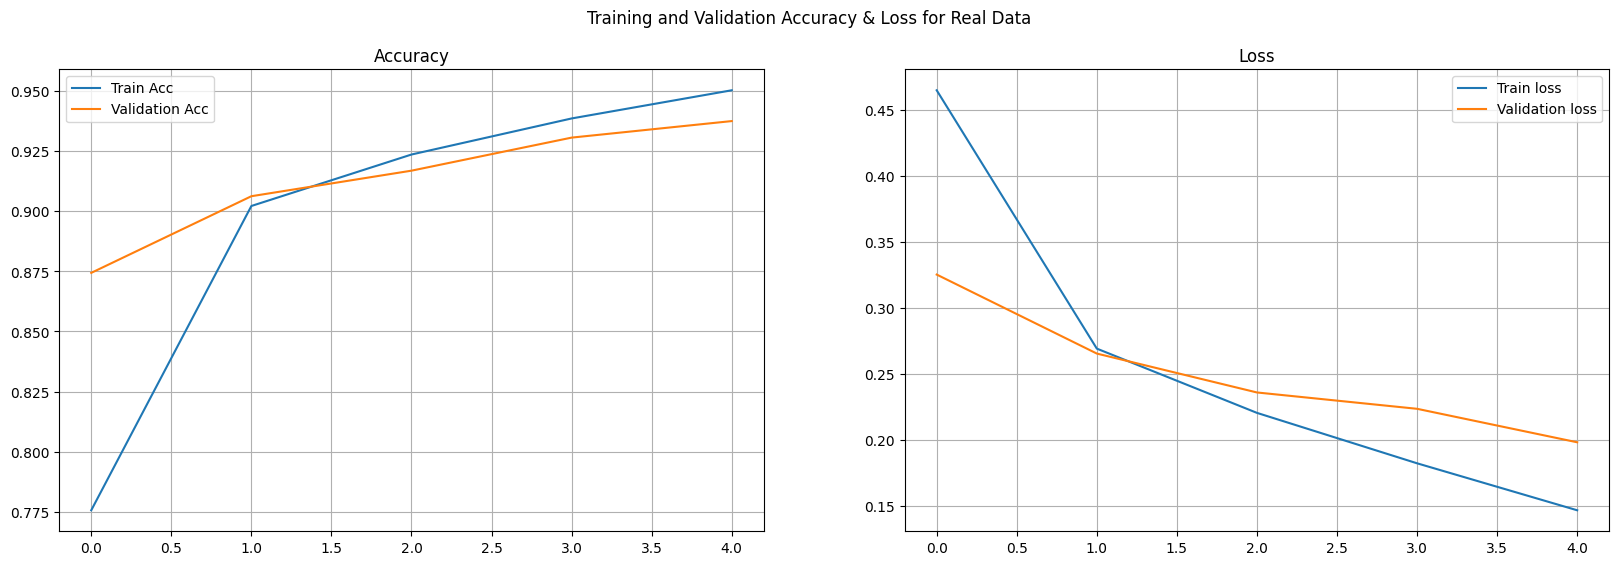

In [14]:
# Plotting Accuracy and Loss for TRaining and Validation Sets
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train Acc")
plt.plot(epoch_vl_acc, label="Validation Acc")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()
fig.suptitle(
    "Training and Validation Accuracy & Loss for Real Data"
)
plt.savefig(
    "../../03_Plots/03_LSTM/01_real_AccLoss.png",
    dpi=300,
)
plt.show()

Test Accuracy: 93.75


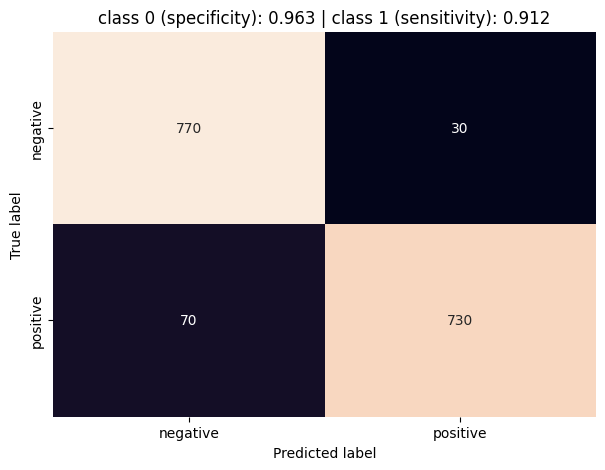

In [15]:
# Calculating Accuracy and confusion matrix
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
    "../../03_Plots/03_LSTM/02_real_cm.png",
    dpi=300,
)

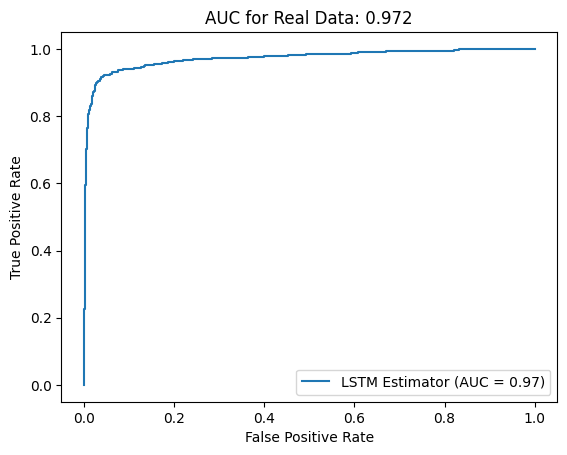

In [16]:
# Plotting ROC Curve
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Estimator"
)
display1.plot()
plt.title("AUC for Real Data: {:.3f}".format(roc_auc))

plt.savefig(
     "../../03_Plots/03_LSTM/03_real_auc.png",
    dpi=300,
)
plt.show()

>Potentially add some example model results here - true positives and true negatives

# Synthetic Data

### Reading Data

In [17]:
# Reading the data (Synthetically Generated data)
syn_training_data = pd.read_csv("../../01_Data/02_Processed/train_syn.csv")
syn_test_data = pd.read_csv("../../01_Data/02_Processed/test_syn.csv")

In [18]:
# Extracting just the features (clean_tweet) and the labels (offensive yes/no)
syn_x_train, syn_y_train = (
    syn_training_data.iloc[:, 0],
    syn_training_data.iloc[:, -1],
)
syn_x_test, syn_y_test = syn_test_data.iloc[:, 0], syn_test_data.iloc[:, -1]
# syn_y_train = syn_y_train.map({"Yes": 1, "No": 0})
# syn_y_test = syn_y_test.map({"Yes": 1, "No": 0})

In [19]:
syn_test_data.head()

,Tweet,Class
0,kd grow bubbl love delet graham period handica...,1
1,ballin eric taylor twerkin insult prefer,1
2,close vomit wish reason nj,0
3,eater wit boi bin im pokemon threw,1
4,music audit everybodi physic unit decemb weird...,0


In [20]:
syn_test_data["Class"].value_counts()

Class
1    800
0    800
Name: count, dtype: int64

### Encoding Synthetic Data

In [21]:
print("x_train before Encoding: ", syn_x_train.shape)
print("Encoding text as Numbers...")
s_x_train, s_y_train, s_x_test, s_y_test, syn_vocab = tokenize_text(
    syn_x_train, syn_y_train, syn_x_test, syn_y_test
)
print("x_train after Encoding: ", s_x_train.shape)

x_train before Encoding:  (6400,)
Encoding text as Numbers...
x_train after Encoding:  (6400, 30)


In [22]:
syn_y_test

0       1
1       1
2       0
3       1
4       0
       ..
1595    1
1596    1
1597    0
1598    0
1599    0
Name: Class, Length: 1600, dtype: int64

In [23]:
real_y_test

0       1
1       0
2       1
3       1
4       0
       ..
1595    0
1596    1
1597    0
1598    1
1599    1
Name: offensive, Length: 1600, dtype: int64

In [24]:
print(f"Length of vocabulary is {len(syn_vocab)}")

Length of vocabulary is 3000


In [25]:
# create Tensor datasets
train_data = TensorDataset(
    torch.from_numpy(s_x_train), torch.from_numpy(s_y_train.astype("int"))
)
valid_data = TensorDataset(
    torch.from_numpy(s_x_test), torch.from_numpy(s_y_test.astype("int"))
)

# dataloaders
batch_size = 50

# Shuffling the data and creating batches of data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

## Model 3B - Discriminative Model trained on Synthetic Data

### LSTM Training on Synthetic Data

In [26]:
# Model Hyperparameters
n_layers = 2
vocab_size = len(syn_vocab) + 1  # extra 1 for padding
embedding_dim = 30
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers, vocab_size, hidden_dim, embedding_dim)

# moving to GPU (if available)
model.to(device)

print(model)
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

LSTMClassifier(
  (embedding): Embedding(3001, 30)
  (lstm): LSTM(30, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [27]:
clip = 5
epochs = 5
best_loss = float("inf")
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(
        epoch + 1,
        epochs,
        epoch_train_loss,
        epoch_val_loss,
        epoch_train_acc * 100,
        epoch_val_acc * 100,
    )
    print(to_print)
    if epoch_val_loss <= best_loss:
        # torch.save(model.state_dict(), 'state_dict.pt')
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                best_loss, epoch_val_loss
            )
        )
        best_loss = epoch_val_loss
        best_model_syn = copy.deepcopy(model)
    print(70 * "==")

Epoch[1/5], Train Loss: 0.6920 | Valid Loss: 0.6911 | Train Acc: 51.91 | Valid Acc: 53.19
Validation loss decreased (inf --> 0.691092).  Saving model ...
Epoch[2/5], Train Loss: 0.6980 | Valid Loss: 0.6908 | Train Acc: 51.34 | Valid Acc: 52.25
Validation loss decreased (0.691092 --> 0.690839).  Saving model ...
Epoch[3/5], Train Loss: 0.6953 | Valid Loss: 0.6913 | Train Acc: 50.44 | Valid Acc: 52.19
Epoch[4/5], Train Loss: 0.6933 | Valid Loss: 0.6918 | Train Acc: 51.14 | Valid Acc: 52.19
Epoch[5/5], Train Loss: 0.6667 | Valid Loss: 0.6868 | Train Acc: 59.00 | Valid Acc: 57.94
Validation loss decreased (0.690839 --> 0.686825).  Saving model ...


### Model Evaluation against validation set

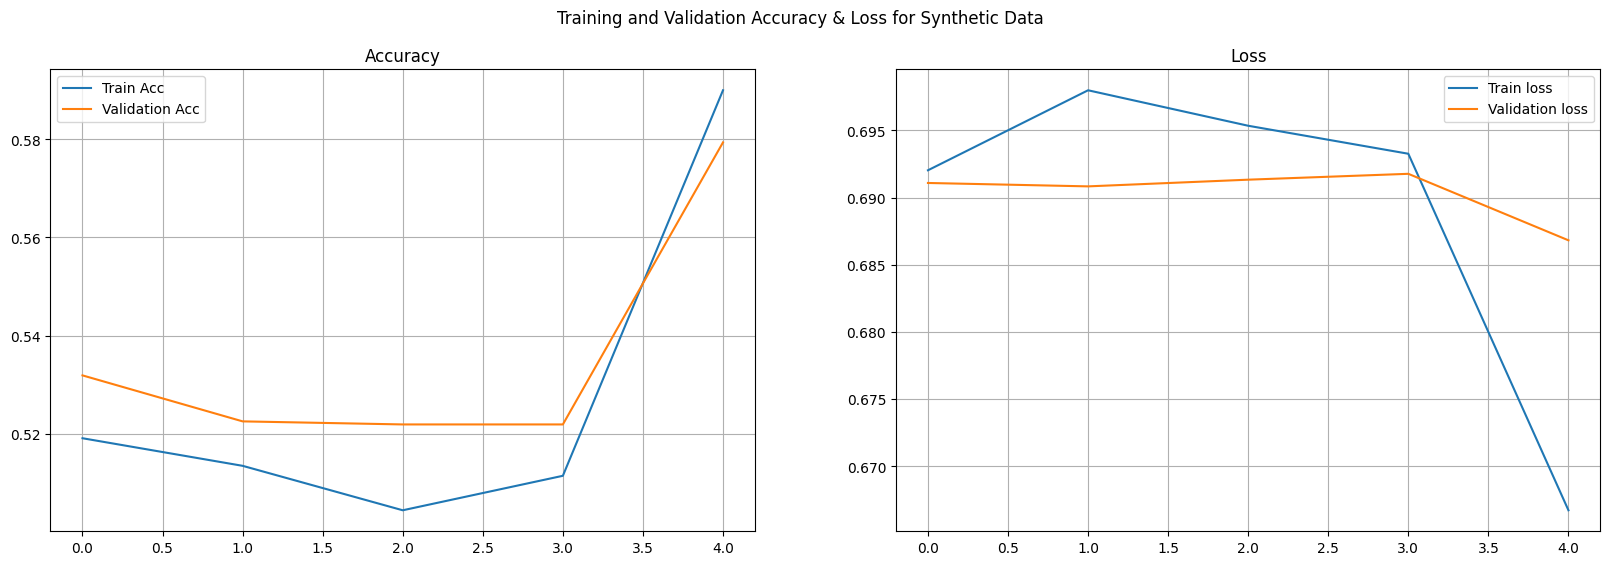

In [28]:
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train Acc")
plt.plot(epoch_vl_acc, label="Validation Acc")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()
fig.suptitle(
    "Training and Validation Accuracy & Loss for Synthetic Data"
)
plt.savefig(
     "../../03_Plots/03_LSTM/04_syn_AccLoss.png",
    dpi=300,
)

plt.show()

Test Accuracy: 57.94


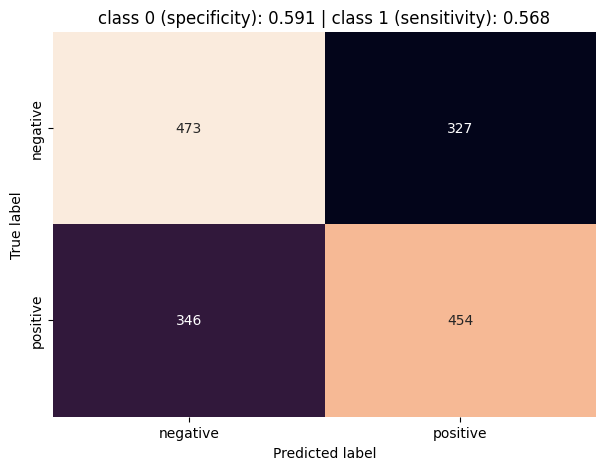

In [29]:
# Calculating Accuracy and confusion matrix
nb_classes = 2
conf_matrix = torch.zeros(nb_classes, nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i = 0

val_h = best_model_syn.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths, ytrue.cpu().numpy())
        ypred, val_h = best_model_syn(inputs, val_h)
        preds = (ypred > 0.5) * 1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred, ytrue)
        val_acc += accuracy
        if i == 0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis=0)
        i += 1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc * 100 / len(valid_loader.dataset)))
accs = np.diag(conf_matrix) / conf_matrix.sum(1)
df_cm = pd.DataFrame(
    conf_matrix,
    index=[i for i in ["negative", "positive"]],
    columns=[i for i in ["negative", "positive"]],
)
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title(
    "class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}".format(
        accs[0], accs[1]
    )
)
plt.savefig(
     "../../03_Plots/03_LSTM/05_syn_cm.png",
    dpi=300,
)

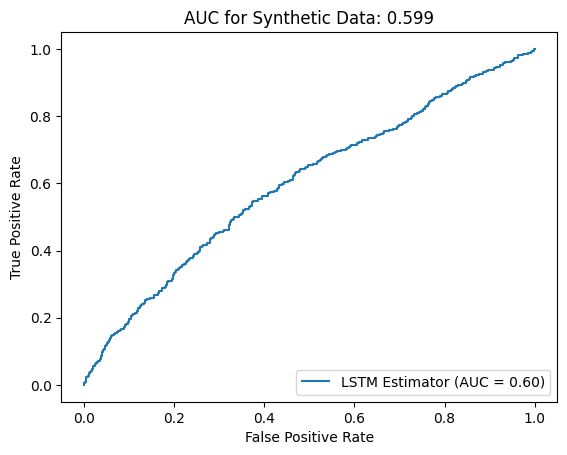

In [30]:
# Plotting ROC Curve
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LSTM Estimator"
)
display1.plot()
plt.title(
    "AUC for Synthetic Data: {:.3f}".format(roc_auc)
)
plt.savefig(
     "../../03_Plots/03_LSTM/06_syn_auc.png",
    dpi=300,
)
plt.show()